In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Nine different asset classes and corresponding ETF ticker
Asset_class = {'Japan':'EWJ',
               'UK':'EWU',
               'Euro':'EZU',
               'China':'FXI',
               'Gold':'GLD',
               'Oil':'USO',
               'Real Estate':'VNQ',
               'US Bond':'SPTL',
               'US Stock':'SPY'}

In [3]:
# Read data and calculate the daily return of each asset class
df = pd.DataFrame()
for asset in Asset_class:
    temp = pd.read_csv('data/'+Asset_class[asset]+'.csv',parse_dates=[0],index_col=[0])
    df[asset] = temp['Adj Close'].pct_change()
df.dropna(inplace=True)

In [4]:
df.head()

,Japan,UK,Euro,China,Gold,Oil,Real Estate,US Bond,US Stock
Date,,,,,,,,,
2007-06-07,-0.004095,-0.016341,-0.025270,-0.008175,-0.017317,0.006758,-0.031447,0.000000,-0.018045
2007-06-08,0.004798,0.013776,0.013534,0.025346,-0.015936,-0.031392,0.011976,0.000000,0.013011
2007-06-11,-0.001364,0.000399,0.001994,0.010804,0.007474,0.015899,-0.014991,-0.018233,0.001722
2007-06-12,-0.012978,-0.008789,-0.017826,-0.019068,-0.009274,-0.005618,-0.017354,0.000000,-0.010905
2007-06-13,0.002768,0.018138,0.016564,0.018392,0.006708,0.010694,0.022144,-0.005307,0.014969


In [5]:
# Calculate the annulized covariance matrix on a rolling 252-day basis
Covariance = df.rolling(252).cov()*252
Covariance.dropna().head()

Japan        UK      Euro     China      Gold       Oil  \
Date                                                                           
2008-06-05 Japan  0.044432  0.032348  0.032410  0.070121  0.005067  0.006512   
           UK     0.032348  0.056993  0.048884  0.084096  0.011147  0.015086   
           Euro   0.032410  0.048884  0.053887  0.083073  0.014952  0.016339   
           China  0.070121  0.084096  0.083073  0.266930  0.014070  0.021529   
           Gold   0.005067  0.011147  0.014952  0.014070  0.043023  0.031694   

                  Real Estate   US Bond  US Stock  
Date                                               
2008-06-05 Japan     0.034107 -0.006379  0.026600  
           UK        0.046176 -0.008862  0.038225  
           Euro      0.042281 -0.008872  0.037335  
           China     0.099284 -0.015480  0.071853  
           Gold     -0.007318  0.000635  0.003045

In [6]:
#Using risk parity to find the weights of the portfolio on each day

#The number of asset class
m = len(Asset_class)

#Initial_guess 
initial_guess = np.array([1/m]*m)

#Equal risk budget
b_vec = [1/m]*m

#Object function to minimize
def get_obj(weights, cov):

    Sigma = np.sqrt(np.matmul(np.matmul(weights.transpose(),cov),weights))
    CR = (np.matmul((np.matmul(np.diag(weights), cov)), weights))/Sigma
    obj_temp = CR - np.multiply(b_vec, Sigma)
    obj = (obj_temp*obj_temp.T)[0,0]
    return obj

#The function which describe the constraint that the sum of weights is one
def con1(x):
    return x.sum()-1



# Find the weights based on risk parity and target volatility
def get_weights(cov):
    #Find the weights based on risk parity
    cov = np.matrix(cov)
    opt_port = minimize(get_obj, initial_guess, args=cov, constraints=({'type': 'eq', 'fun': con1}), tol=1e-10)                                                            
    weights_rp = opt_port.x.round(6)
    
    #Leverage to meet the target volatility
    vol_rp = np.sqrt(np.matmul(np.matmul(weights_rp.transpose(),cov),weights_rp))
    US_vol = df['US Stock'].std()*np.sqrt(252)
    vol_high = US_vol*1.2167
    vol_low = US_vol*0.8251
    leverage_high = vol_high/vol_rp
    weights_high = leverage_high*weights_rp
    leverage_low = vol_low/vol_rp
    weights_low = leverage_low*weights_rp
    return pd.DataFrame({'weights_high':np.array(weights_high).flatten(),
                         'weights_low':np.array(weights_low).flatten(),
                         'weights_rp':np.array(weights_rp).flatten()},index=df.keys())
           


In [7]:
#Calculate the portfolio return based on risk parity
Port = Covariance.dropna().groupby('Date').apply(get_weights)
Port.rename_axis(['Date','Asset'],inplace=True)
Port = Port.groupby('Asset').shift()
Port['ret'] = df.stack()
Port.dropna(inplace=True)
Port['weighted ret high'] = Port['weights_high']*Port['ret']
Port['weighted ret rp'] = Port['weights_rp']*Port['ret']
Port['weighted ret low'] = Port['weights_low']*Port['ret']
Port_ret_high = Port['weighted ret high'].groupby('Date').sum()
Port_ret_rp = Port['weighted ret rp'].groupby('Date').sum()
Port_ret_low = Port['weighted ret low'].groupby('Date').sum()

In [8]:
#Calculate the benchmark return based on naive asset allocation(1/N)
benchmark = Port.copy()
benchmark['weights'] = 1/9
benchmark['weighted ret'] = benchmark['weights']*benchmark['ret']
benchmark_ret = benchmark['weighted ret'].groupby('Date').sum()

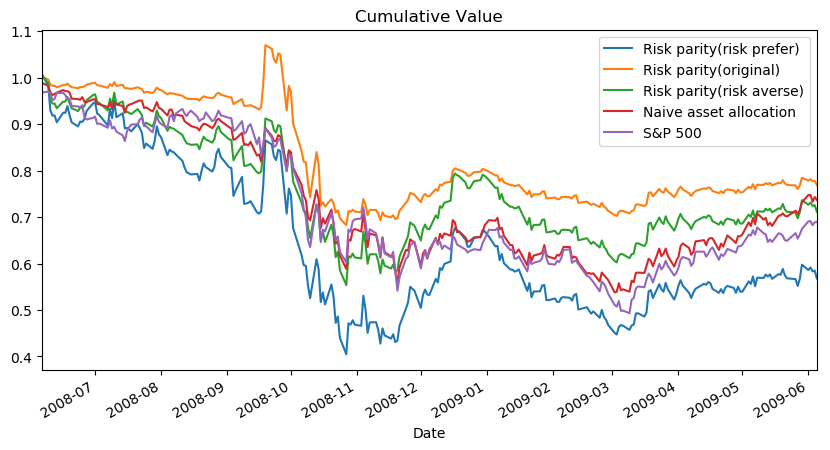

In [10]:
plt.figure(figsize=(10,5),dpi=100)
(Port_ret_high+1).cumprod().plot()
(Port_ret_rp+1).cumprod().plot()
(Port_ret_low+1).cumprod().plot()
(benchmark_ret+1).cumprod().plot()
US_stock_ret = df['US Stock'].loc[Port_ret_high.index]
(US_stock_ret+1).cumprod().plot()
plt.legend(['Risk parity(risk prefer)','Risk parity(original)','Risk parity(risk averse)','Naive asset allocation','S&P 500'])
plt.title('Cumulative Value')
plt.show()

In [12]:
#Annualized statistics
def get_stats(ret):
    Mean = (ret.mean()+1)**252-1
    Vol = ret.std()*np.sqrt(252)
    Sharpe_ratio = Mean/Vol
    cum_ret = (ret+1).cumprod()
    MaxDD = np.min(cum_ret/cum_ret.cummax()-1)
    return pd.Series([Mean,Vol,Sharpe_ratio,MaxDD],index=['Mean','Volatility','Sharpe Ratio','Maximum Drawdown'])

stats = pd.DataFrame()
stats['Risk parity(risk prefer)'] = get_stats(Port_ret_high)
stats['Risk parity(original)'] = get_stats(Port_ret_rp)
stats['Risk parity(risk averse)'] = get_stats(Port_ret_low)
stats['Naive asset allocation'] = get_stats(benchmark_ret)
stats['S&P 500'] = get_stats(US_stock_ret)
stats

,Risk parity(risk prefer),Risk parity(original),Risk parity(risk averse),Naive asset allocation,S&P 500
Mean,-0.307575,-0.192852,-0.220574,-0.195271,-0.235677
Volatility,0.631538,0.309359,0.428275,0.420794,0.456329
Sharpe Ratio,-0.487025,-0.623394,-0.515029,-0.464053,-0.516464
Maximum Drawdown,-0.598551,-0.362187,-0.449192,-0.456064,-0.491979
